# Baseline classifier
ReLU activation, 4 layers, 100 neurons per layer
Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *
from keras.models import load_model

Using TensorFlow backend.


## Options

In [2]:
with open(dirLoc + 'features.pkl', 'rb') as fin:
    classTrainFeatures = pickle.load(fin)

In [3]:
nSplits = 10
patience = 50
maxEpochs = 200
preTrainMaxEpochs = 10

ensembleSize = 10
ensembleMode = 'loss'

compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':'modelRelu', 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

name = "weights/ReLU_Baseline_CLR_AsimovLoss"
name_pretrain = name.replace('weights/', 'weights/PRETRAIN_')

print ("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


# b = 100000  # test
# t = 250000  # training
# v = 450000  # test

# sig weight sum:  1383.97719575 in 550000
# bkg weight sum:  821999.696026 in 550000

# expected signal and background numbers
s_exp = 1383.97719575 / 550000 * 800000
b_exp = 821999.696026 / 550000 * 800000
print ('_S%.2e'%s_exp).replace('.', 'd').replace('+','p').replace('-','m')
print ('_B%.2e'%b_exp).replace('.', 'd').replace('+','p').replace('-','m')

new_loss_functions = get_losses_dict([0.5], s_exp, b_exp)

('\nTraining on', 31, 'features:', ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py'])
_S2d01ep03
_B1d20ep06


## Import data

In [4]:
trainData = BatchYielder(h5py.File(dirLoc + 'train.hdf5', "r+"))

## Determine LR

(2, 'classes found, running in binary mode\n')

______________________________________
Training finished
Cross-validation took 10.362s 


/nfs/dust/cms/user/tholenhe/installs/anaconda2/envs/hepML3/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


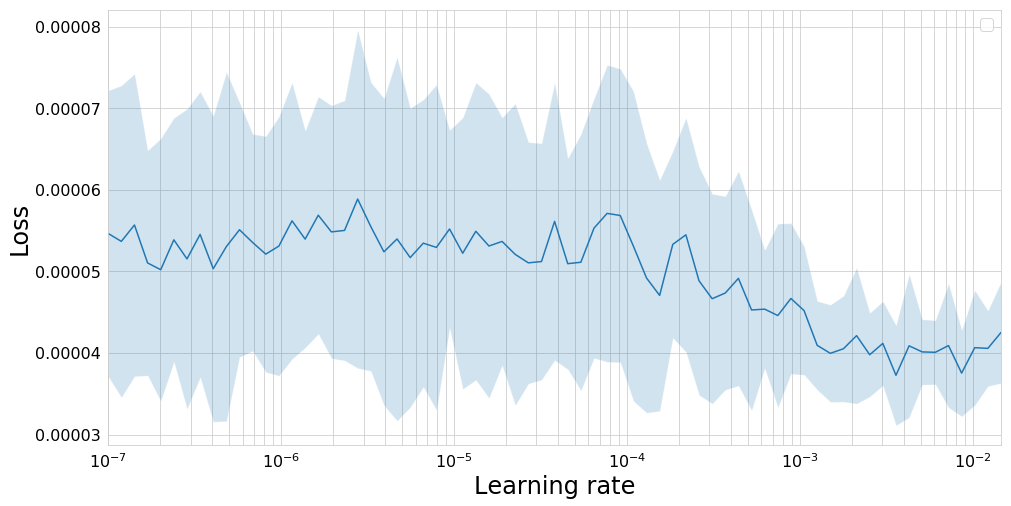

______________________________________



In [7]:
def my_model(**_):
    return model

lrFinder = batchLRFind(trainData, my_model, modelParams, trainParams,
                       lrBounds=[1e-7,1e-1], trainOnWeights=True, verbose=0)

## Train classifier

<b>Cross-entropy</b> pre-training with ``preTrainMaxEpochs``

In [5]:
newModelArgs = modelParams.copy()
newModelArgs['compileArgs'] = compileArgs.copy()
newModelArgs['compileArgs']['lr'] = 2e-3
trainParams['batch_size'] = 256
patience = 20  # is 50 above

In [6]:
# need to modify the model later
model = getModel(**newModelArgs)

In [7]:
results, histories = batchTrainClassifier(trainData, nSplits, lambda: model, {},  # model exist already
                                          trainParams, trainOnWeights=True, maxEpochs=preTrainMaxEpochs,
                                          cosAnnealMult=2, plotLR=1, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000)

Using cosine annealing
Training using weights
('Running fold', 1, '/', 10)
(2, 'classes found, running in binary mode\n')
1 New best found: 3.98802124319e-05
2 New best found: 3.74467441037e-05
3 New best found: 3.6887203755e-05
5 New best found: 3.61304489965e-05
6 New best found: 3.56875210444e-05
7 New best found: 3.54678168896e-05
9 New best found: 3.52216042936e-05
11 New best found: 3.49619363169e-05
12 New best found: 3.47053261209e-05
13 New best found: 3.44428630766e-05
14 New best found: 3.43312294309e-05
15 New best found: 3.43044951932e-05
20 New best found: 3.42726622721e-05
22 New best found: 3.42327866227e-05
23 New best found: 3.40942031233e-05
24 New best found: 3.37549742913e-05
25 New best found: 3.36846618459e-05
29 New best found: 3.35130295117e-05
30 New best found: 3.35076284526e-05
31 New best found: 3.34991123839e-05


KeyboardInterrupt: 

In [ ]:
model.save(name_pretrain+'_model_step1.h5')

In [7]:
model = load_model(name_pretrain+'_model_step1.h5')

<b>Significance-loss</b> pre-training with ``preTrainMaxEpochs``

In [7]:
# recompile with new loss
#loss = new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S2d01ep03_B1d20ep06']
#loss = new_loss_functions['significanceLoss2Invert_S2d01ep03_B1d20ep06']
loss = new_loss_functions['sOverBLossInvert_S2d01ep03_B1d20ep06']
newModelArgs['compileArgs']['lr'] = 5e-4
newModelArgs['compileArgs']['loss'] = loss
trainParams['batch_size'] = 8192

new_model = getModel(**newModelArgs)
new_model.set_weights(model.get_weights())
model = new_model

weights is Tensor-placeholder, continuing with weights=1.


In [8]:
results, histories = batchTrainClassifier(trainData, nSplits, lambda: model, {},  # model exist already
                                          trainParams, trainOnWeights=True, maxEpochs=preTrainMaxEpochs,
                                          cosAnnealMult=2, plotLR=1, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000)

Using cosine annealing
Training using weights
('Running fold', 1, '/', 10)
(2, 'classes found, running in binary mode\n')
1 New best found: nan


KeyboardInterrupt: 

In [ ]:
model.save(name_pretrain+'_model_step2.h5')

In [12]:
model = load_model(name_pretrain+'_model_step2.h5', custom_objects=new_loss_functions)

ValueError: Unknown loss function:significanceLoss2Invert

<b>Asimov-significance-loss</b> training with ``maxEpochs``

In [ ]:
# recompile with new loss
newModelArgs['compileArgs']['lr'] = 5e-4
trainParams['batch_size'] = 8192
model.compile(
    loss=new_loss_functions['asimovSignificanceLossInvert_Sys0p5_S2d01ep03_B1d20ep06'],
    optimizer=getOptimizer(newModelArgs['compileArgs'])
)

Using cosine annealing
Training using weights
('Running fold', 1, '/', 10)
(2, 'classes found, running in binary mode\n')
1 New best found: 997.634437807
CosineAnneal stalling after 7 epochs, entering redux decay at LR=7.90602752726e-09
Early stopping after 17 epochs
('Score is:', {'loss': 997.6344378074348, 'AUC': 0.10572210640306001, 'cut': 0.903377115726471, 'wAUC': 0.06914746990461618, 'AMS': 3.5060555576644687})


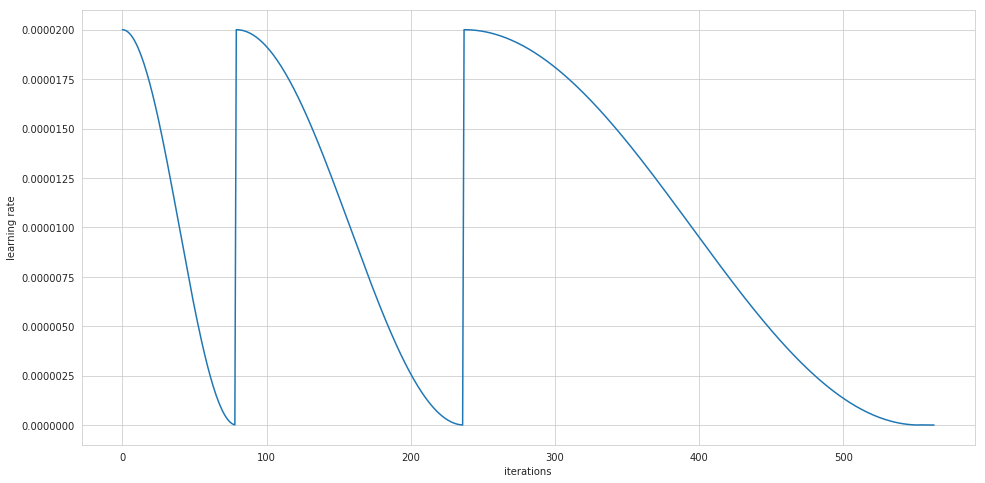

Fold took 28.470s

('Running fold', 2, '/', 10)
1 New best found: 0.247881399423
CosineAnneal stalling after 7 epochs, entering redux decay at LR=3.35572643857e-13
Early stopping after 17 epochs
('Score is:', {'loss': 0.2478813994231074, 'AUC': 0.10379048791098033, 'cut': 0.9057424664497375, 'wAUC': 0.06747136750015426, 'AMS': 3.66263553794874})


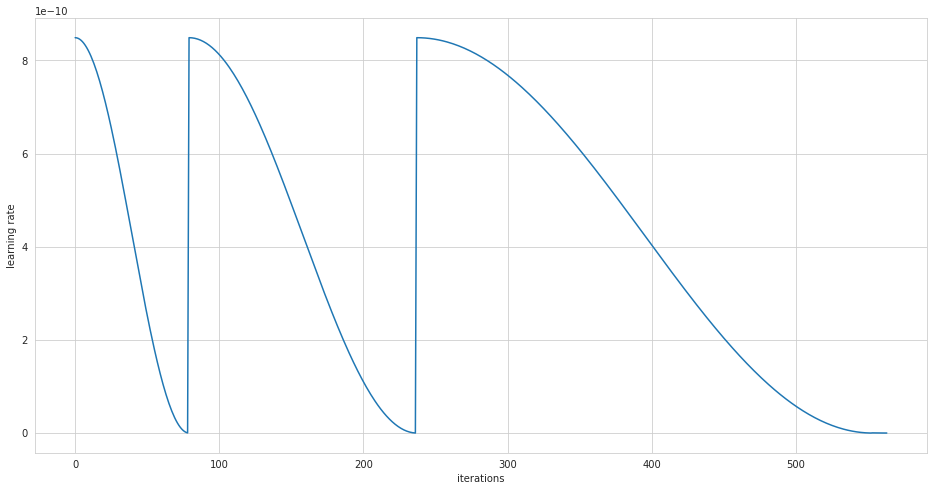

Fold took 26.029s

('Running fold', 3, '/', 10)
1 New best found: 0.0151824667585
CosineAnneal stalling after 7 epochs, entering redux decay at LR=1.42434361765e-17
Early stopping after 17 epochs
('Score is:', {'loss': 0.015182466758465159, 'AUC': 0.10217240739640887, 'cut': 0.9086645245552063, 'wAUC': 0.06198064870785469, 'AMS': 3.7273675706031617})


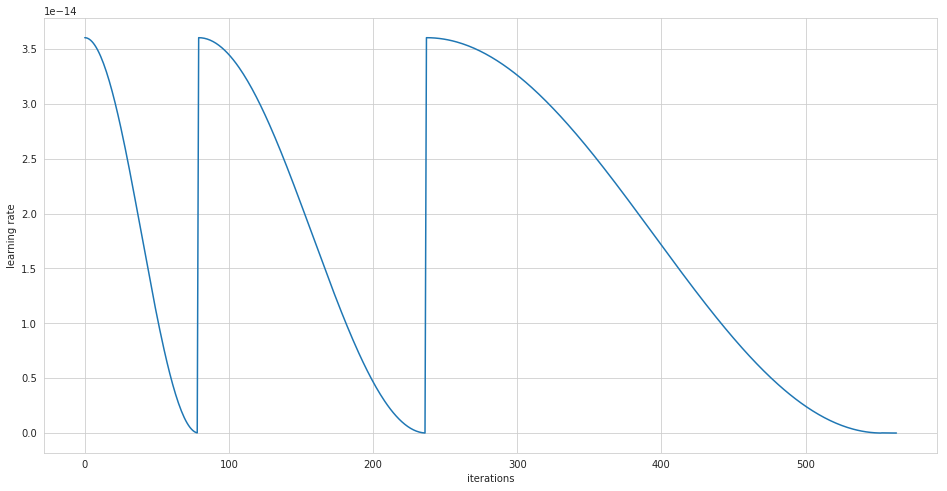

Fold took 26.471s

('Running fold', 4, '/', 10)
1 New best found: 0.00103523184864
CosineAnneal stalling after 7 epochs, entering redux decay at LR=6.04564940487e-22
Early stopping after 17 epochs
('Score is:', {'loss': 0.001035231848640251, 'AUC': 0.10499333382674536, 'cut': 0.9442324042320251, 'wAUC': 0.06260265581383129, 'AMS': 3.6916469928790905})


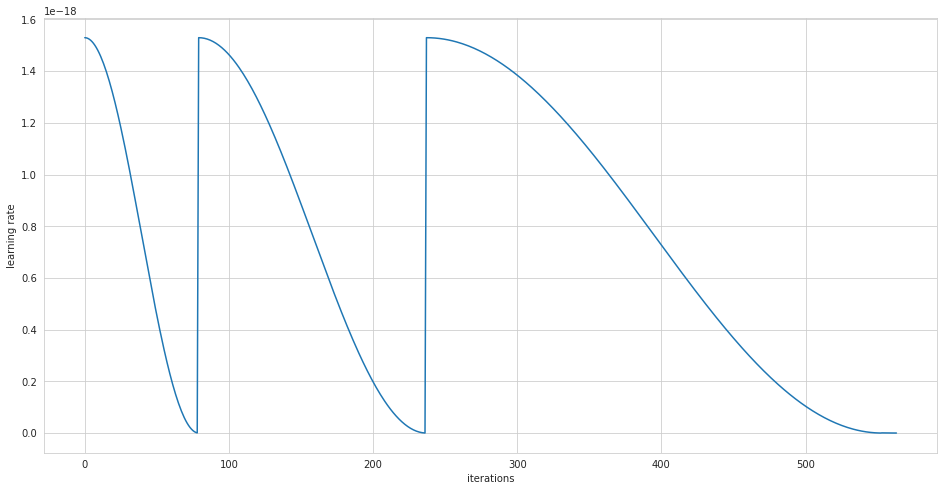

Fold took 26.401s

('Running fold', 5, '/', 10)
1 New best found: 0.00118312232044
CosineAnneal stalling after 7 epochs, entering redux decay at LR=2.56608564293e-26
Early stopping after 17 epochs
('Score is:', {'loss': 0.0011831223204440903, 'AUC': 0.10055177460457876, 'cut': 0.9229092001914978, 'wAUC': 0.060889126813947314, 'AMS': 3.8549380355349947})


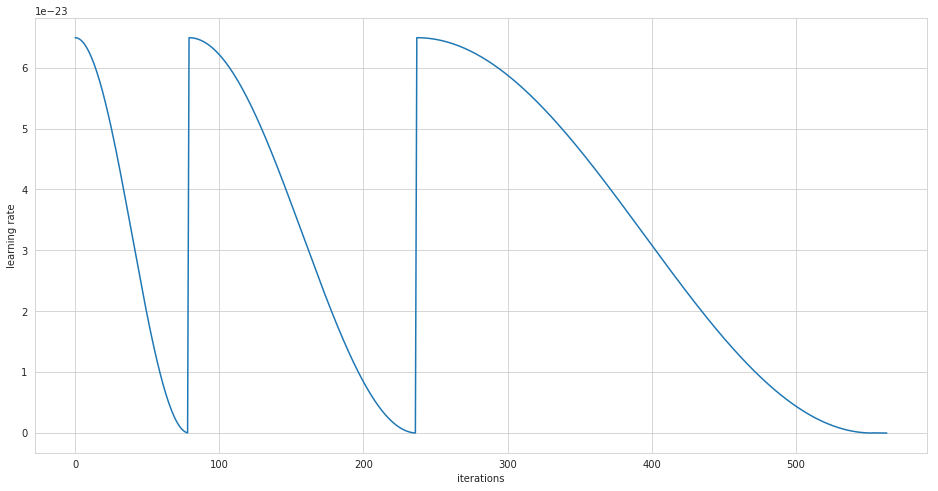

Fold took 27.098s

('Running fold', 6, '/', 10)
1 New best found: 0.00102765175821
CosineAnneal stalling after 7 epochs, entering redux decay at LR=1.08917919839e-30
Early stopping after 17 epochs
('Score is:', {'loss': 0.0010276517582140513, 'AUC': 0.10250875103221169, 'cut': 0.9072351455688477, 'wAUC': 0.061419064998995854, 'AMS': 3.960794972147397})


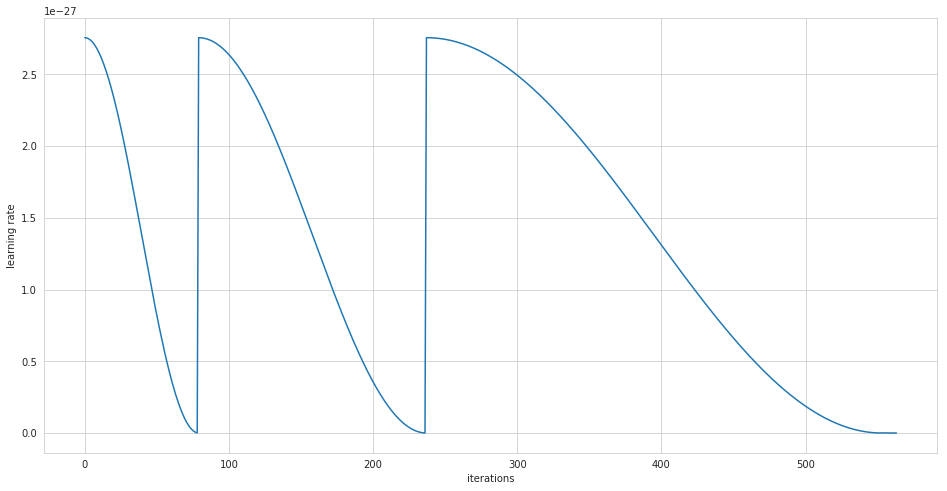

Fold took 25.931s

('Running fold', 7, '/', 10)
1 New best found: 0.00122723807589
CosineAnneal stalling after 7 epochs, entering redux decay at LR=4.62303869924e-35
Early stopping after 17 epochs
('Score is:', {'loss': 0.0012272380758891813, 'AUC': 0.10196348578111092, 'cut': 0.916100263595581, 'wAUC': 0.060362335327082794, 'AMS': 3.643099936082207})


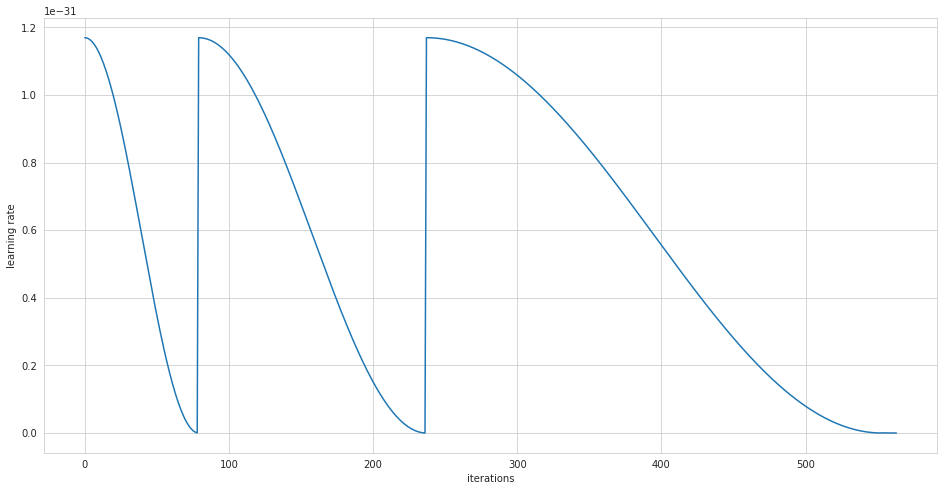

Fold took 26.460s

('Running fold', 8, '/', 10)
1 New best found: 0.000962116691123
CosineAnneal stalling after 7 epochs, entering redux decay at LR=1.9622564563e-39
Early stopping after 17 epochs
('Score is:', {'loss': 0.0009621166911234998, 'AUC': 0.09913325750677793, 'cut': 0.9159631133079529, 'wAUC': 0.058365095024061286, 'AMS': 3.658517377272334})


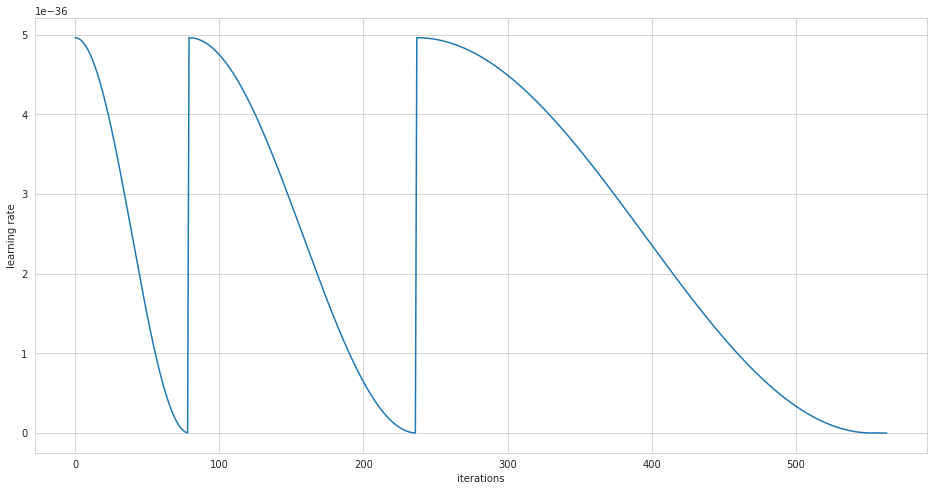

Fold took 25.958s

('Running fold', 9, '/', 10)
1 New best found: 0.00103641746659
CosineAnneal stalling after 7 epochs, entering redux decay at LR=8.3288038721e-44
Early stopping after 17 epochs
('Score is:', {'loss': 0.0010364174665883066, 'AUC': 0.10079961115452796, 'cut': 0.961891770362854, 'wAUC': 0.0623529420054042, 'AMS': 4.129002775397669})


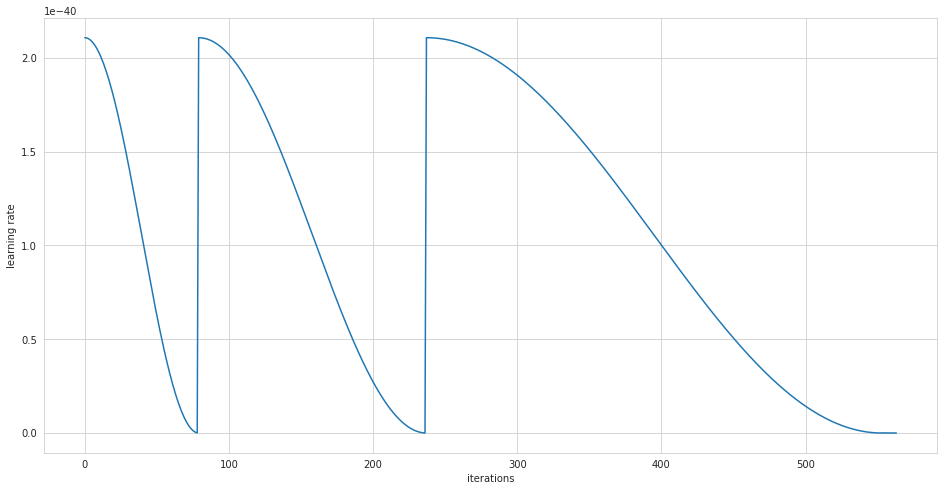

Fold took 26.134s

('Running fold', 10, '/', 10)
1 New best found: 0.00157061290396
CosineAnneal stalling after 7 epochs, entering redux decay at LR=3.32361135382e-48
Early stopping after 17 epochs
('Score is:', {'loss': 0.0015706129039557088, 'AUC': 0.10487093979031148, 'cut': 0.9117695689201355, 'wAUC': 0.0634105123698524, 'AMS': 3.6529654356391146})


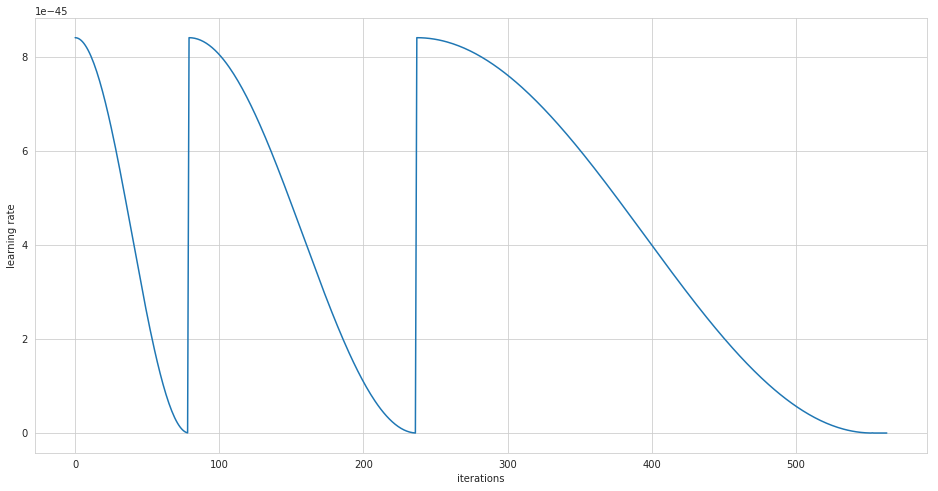

Fold took 26.497s


______________________________________
Training finished
Cross-validation took 266.628s 


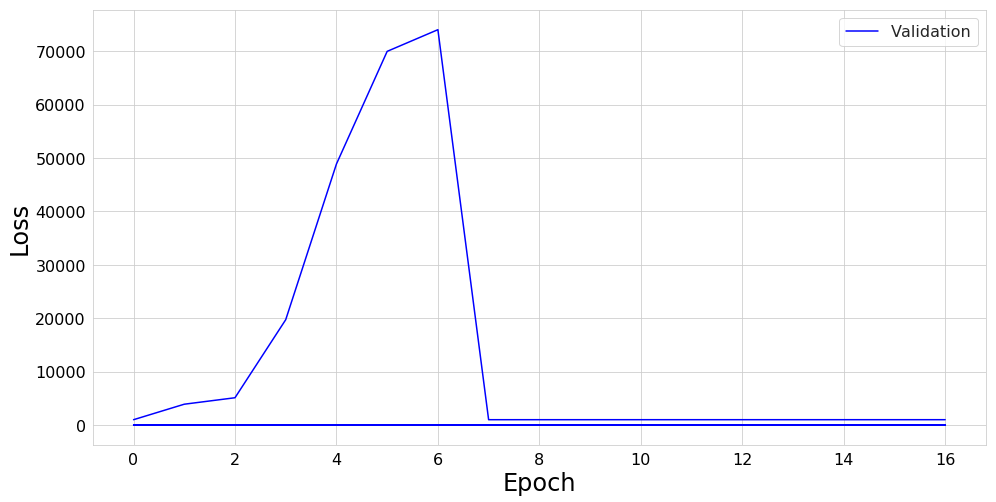

('Mean', 'loss', '= 100 +- 95')
('Mean', 'AUC', '= 0.1027 +- 0.0006')
('Mean', 'cut', '= 0.92 +- 0.006')
('Mean', 'wAUC', '= 0.0628 +- 0.001')
('Mean', 'AMS', '= 3.75 +- 0.05')
______________________________________



<Figure size 432x288 with 0 Axes>

In [19]:
results, histories = batchTrainClassifier(trainData, nSplits, lambda: model, {},  # model exist already
                                          trainParams, trainOnWeights=True, maxEpochs=maxEpochs,
                                          cosAnnealMult=2, plotLR=1, reduxDecay=1,  # this line added
                                          patience=patience, verbose=1, amsSize=250000)

In [20]:
model.save(name_pretrain+'_model_step3.h5')

In [23]:
model = load_model(name_pretrain+'_model_step3.h5', custom_objects=new_loss_functions)

## Construct ensemble

In [37]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:
    results = pickle.load(fin)

In [38]:
ensemble, weights = assembleEnsemble(
    results, ensembleSize, ensembleMode, compileArgs, custom_objects=new_loss_functions)

('Choosing ensemble by', 'loss')
('Model', 0, 'is', 5, 'with', 'loss', '=', 6.5919078715580785e-06)
('Model', 1, 'is', 3, 'with', 'loss', '=', 6.9395938768764155e-06)
('Model', 2, 'is', 8, 'with', 'loss', '=', 6.971252774348411e-06)
('Model', 3, 'is', 4, 'with', 'loss', '=', 7.068618392077042e-06)
('Model', 4, 'is', 0, 'with', 'loss', '=', 7.684439717226177e-06)
('Model', 5, 'is', 7, 'with', 'loss', '=', 1.1029629611744357e-05)
('Model', 6, 'is', 6, 'with', 'loss', '=', 1.1579027890525139e-05)
('Model', 7, 'is', 1, 'with', 'loss', '=', 1.810529529710932e-05)
('Model', 8, 'is', 9, 'with', 'loss', '=', 0.000759961206473795)
('Model', 9, 'is', 2, 'with', 'loss', '=', 0.00639978450168905)


## Response on validation datawith no ensembling

In [6]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [7]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 7.79918193817e-05s per sample

Predicting batch 2 out of 10
Prediction took 2.99613952637e-05s per sample

Predicting batch 3 out of 10
Prediction took 3.04116249084e-05s per sample

Predicting batch 4 out of 10
Prediction took 2.9611825943e-05s per sample

Predicting batch 5 out of 10
Prediction took 3.03711891174e-05s per sample

Predicting batch 6 out of 10
Prediction took 2.90228366852e-05s per sample

Predicting batch 7 out of 10
Prediction took 2.98099994659e-05s per sample

Predicting batch 8 out of 10
Prediction took 2.9656791687e-05s per sample

Predicting batch 9 out of 10
Prediction took 2.99531936646e-05s per sample

Predicting batch 10 out of 10
Prediction took 2.93812274933e-05s per sample

CPU times: user 8.37 s, sys: 26.5 s, total: 34.8 s
Wall time: 1.74 s


In [41]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.890331129165, weighted 0.923919586313


In [11]:
%%time
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')
CPU times: user 19.2 s, sys: 0 ns, total: 19.2 s
Wall time: 41.5 s


(3.574477842890102, 0.9527582)

In [12]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.6+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.947619539453, corresponds to AMS of 3.52228979407
CPU times: user 2.71 s, sys: 10 s, total: 12.7 s
Wall time: 57.8 s


(3.6, 0.95)

# Test scoring with no ensembling

In [8]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [9]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=1, verbose=1)

Predicting batch 1 out of 10
Prediction took 3.15325650302e-05s per sample

Predicting batch 2 out of 10
Prediction took 3.2532566244e-05s per sample

Predicting batch 3 out of 10
Prediction took 5.06539084695e-05s per sample

Predicting batch 4 out of 10
Prediction took 4.08076719804e-05s per sample

Predicting batch 5 out of 10
Prediction took 3.20927663283e-05s per sample

Predicting batch 6 out of 10
Prediction took 2.97755631534e-05s per sample

Predicting batch 7 out of 10
Prediction took 2.99191301519e-05s per sample

Predicting batch 8 out of 10
Prediction took 2.91876359419e-05s per sample

Predicting batch 9 out of 10
Prediction took 2.94866345145e-05s per sample

Predicting batch 10 out of 10
Prediction took 2.93970888311e-05s per sample

CPU times: user 1min 30s, sys: 5min 1s, total: 6min 32s
Wall time: 18.5 s


In [44]:
scoreTestOD(testData.source, 0.9417530075879768)

Public:Private AMS: 3.18253691892 : 3.22240702412


(3.1825369189224144, 3.222407024124467)

## Response on validation data with ensembling

In [12]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=ensembleSize, verbose=1)

Predicting batch 1 out of 10
Prediction took 0.00228306460381s per sample

Predicting batch 2 out of 10
Prediction took 0.000429398202896s per sample

Predicting batch 3 out of 10
Prediction took 0.000415598011017s per sample

Predicting batch 4 out of 10
Prediction took 0.000415959978104s per sample

Predicting batch 5 out of 10
Prediction took 0.000417320013046s per sample

Predicting batch 6 out of 10
Prediction took 0.000413268184662s per sample

Predicting batch 7 out of 10
Prediction took 0.000415294027328s per sample

Predicting batch 8 out of 10
Prediction took 0.000417959976196s per sample

Predicting batch 9 out of 10
Prediction took 0.000425527238846s per sample

Predicting batch 10 out of 10
Prediction took 0.000413608407974s per sample

CPU times: user 2min 9s, sys: 6min 21s, total: 8min 31s
Wall time: 30.2 s


In [18]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source))))

Testing ROC AUC: unweighted 0.897939621566, weighted 0.933283232346


In [19]:
amsScanSlow(convertToDF(valData.source))

(50000, 'candidates loaded')


(3.715117458996407, 0.9555341)

In [20]:
%%time
bootstrapMeanAMS(convertToDF(valData.source), N=512)

(50000, 'candidates loaded')

Mean AMS=3.8+-0.1, at mean cut of 0.95+-0.01
Exact mean cut 0.950024582446, corresponds to AMS of 3.69339872363
CPU times: user 2.59 s, sys: 9.73 s, total: 12.3 s
Wall time: 56.6 s


(3.8, 0.95)

# Test scoring

In [11]:
testData = BatchYielder(h5py.File(dirLoc + 'testing.hdf5', "r+"))

In [16]:
%%time
batchEnsemblePredict(ensemble, weights, testData, ensembleSize=ensembleSize, verbose=1)

NameError: name 'ensemble' is not defined

In [23]:
scoreTestOD(testData.source, 0.9394347775960341)

Public:Private AMS: 3.6170575304 : 3.61021225312


(3.6170575303988963, 3.610212253117004)

# Save/Load

In [45]:
saveEnsemble(name, ensemble, weights, compileArgs, overwrite=True)

In [5]:
ensemble, weights, compileArgs, _, _ = loadEnsemble(name, custom_objects=new_loss_functions)

# Plotting

(50000, 'candidates loaded')


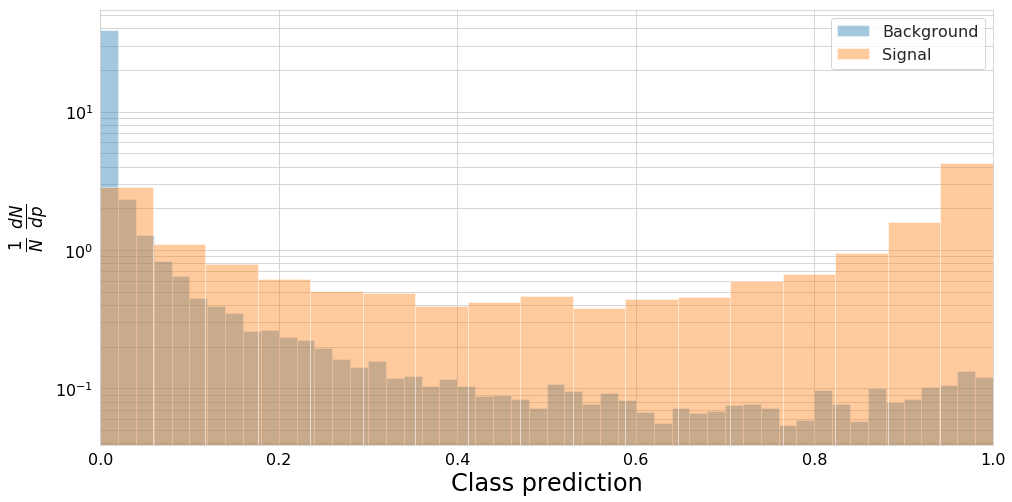

In [46]:
d = convertToDF(valData.source)
bkg_sig_dfs = [
    d[d['gen_target']==0],
    d[d['gen_target']==1],
]
getClassPredPlot(bkg_sig_dfs, weightName='gen_weight')

(50000, 'candidates loaded')
0 ROC AUC: 0.923919586313


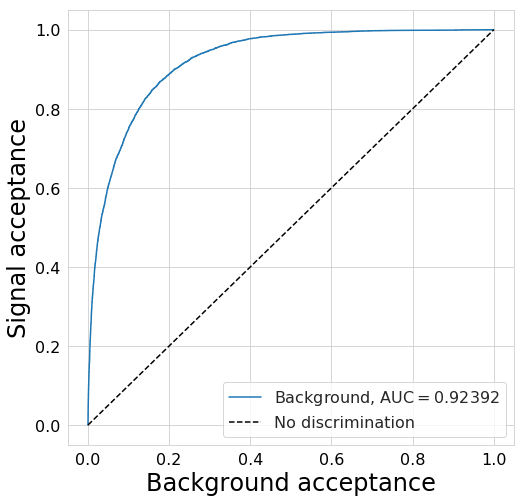

In [47]:
rocPlot([convertToDF(valData.source)], weightName='gen_weight', labels=['Background', 'Signal'])

(550000, 'candidates loaded')


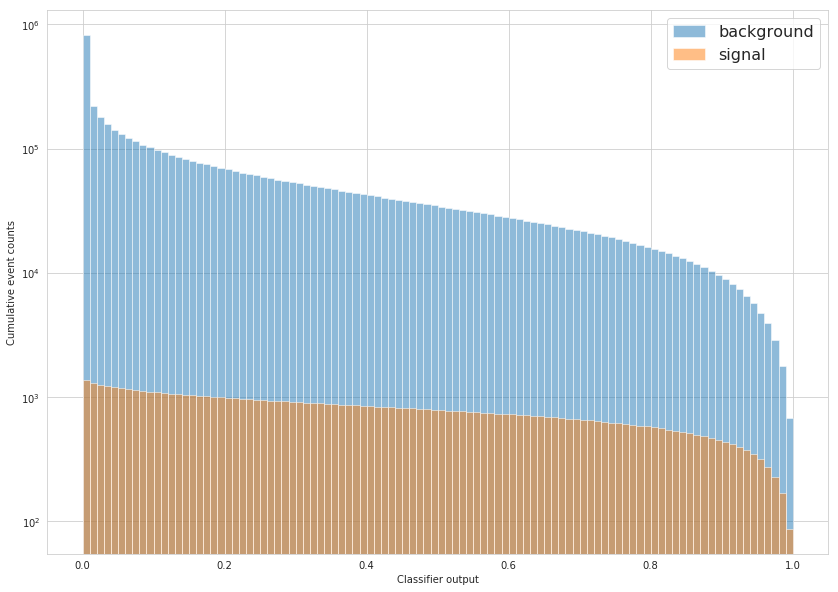

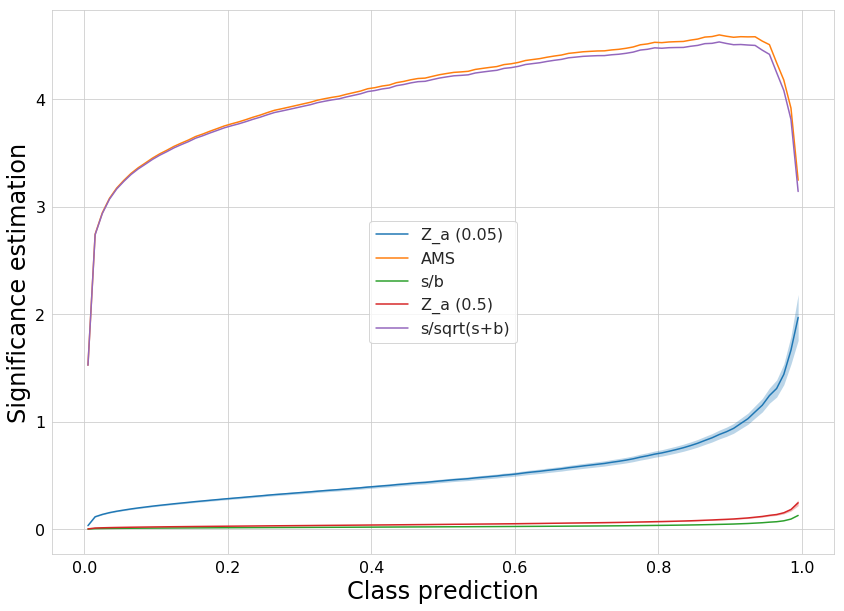

CPU times: user 1.07 s, sys: 68 ms, total: 1.14 s
Wall time: 1.05 s


In [48]:
%%time 

from numpy import sqrt, log, power

def get_asimov(systematic):
    return lambda s,b: (Z_asimov(s,b, systematic), eZ_asimov(s,sqrt(s),b,sqrt(b),systematic))

h1 = plotSignificanceEstimate(
    convertToDF(testData.source), 
    {
        's/b': lambda s,b: s/b,
        's/sqrt(s+b)': lambda s,b: s/np.sqrt(s+b),
        'Z_a (0.5)': get_asimov(0.5),
        'Z_a (0.05)': get_asimov(0.05),
        'AMS': AMS,
#        'asimov err': lambda s,b: eZ(s,sqrt(s),b,sqrt(b)),
    },
    weightName='gen_weight',
    figsize=(14, 10),
    nBins=100,
)